In [187]:
import pandas as pd
import numpy as np
import joblib
import zipfile
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive
# ---------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
plt.rcParams['figure.figsize']=(17,5)

# ---------------------------------------
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

# ---------------------------------------
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

### Outline

- <a href = #link1>  1. Data Overview </a>
- <a href = #link2>  2. Exploratory Data Analysis (EDA) </a>
- <a href = #link3>  3. Data Preprocessing </a>
- <a href = #link4>  4. Model evulate </a>
- <a href = #link5>  5. Final model </a>




# <a name='link1'>  1. Data Overview</a>

**Kết nối đến Drive**

In [188]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
file_path_data = '/content/drive/My Drive/RF and XGB/AEP_hourly.csv.zip'

# Tên tệp CSV
csv_file_name = "AEP_hourly.csv"

# Mở file zip và đọc file CSV bên trong
with zipfile.ZipFile(file_path_data, 'r') as zip_ref:
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file, index_col=[0], parse_dates=[0])
print(df.head())


                      AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0


# Dữ liệu gồm có chi tiết ngày và giờ cụ thể với lượng điện tiêu thụ cụ thể theo từng giờ
# Bài toán của chúng ta được đặt ra là làm thế nào để có thể dự đoán gần chính xác lượng điện tiêu thụ. Cung cấp cho mọi nơi để có kết quả không thiếu điện
# Chúng ta sẽ tìm hiểu xem các biến động về dự đoán điện ở nhiều model xem tháng nào khó dự đoán nhất và chi tiết tại sao

In [190]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


# Dữ liệu trong khoảng từ năm 2004-2018

# Xem xét các thống kê cơ bản

In [191]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP_MW,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.0,25695.0


Ta thấy rằng dữ liệu trung bình và trung vị không cách nhau quá xa với số lớn nhất là 25695

#  Dữ liệu bị thiếu

In [192]:
df.isna().sum()

AEP_MW    0
dtype: int64

# <a name='link2'>  2. Exploratory Data Analysis (EDA)</a>

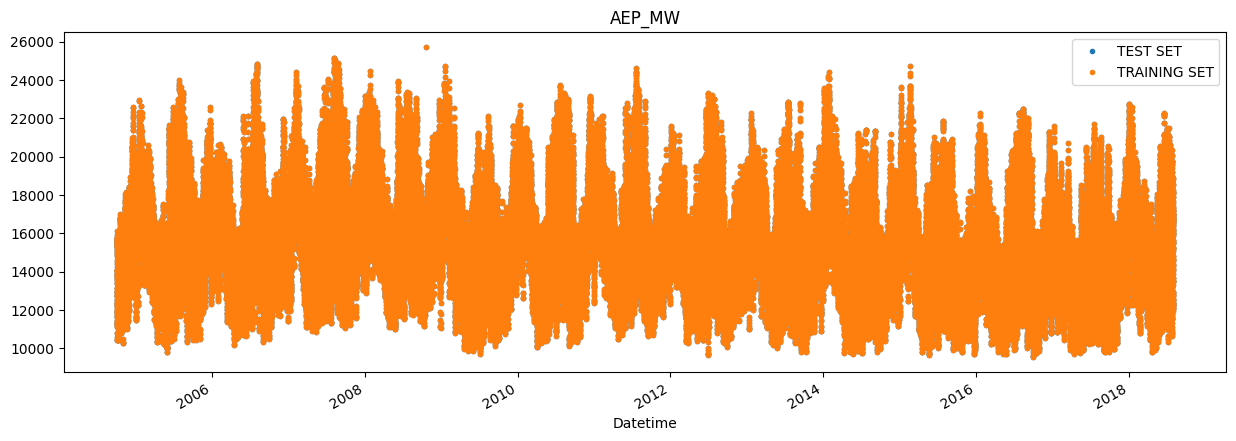

In [193]:
_ = df.rename(columns={'AEP_MW': 'TEST SET'}).join(df.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='AEP_MW', style='.')

# CHúng tôi chia train test trc để đảm bảo không có sai lầm nào của dữ liệu khi đi khám phá

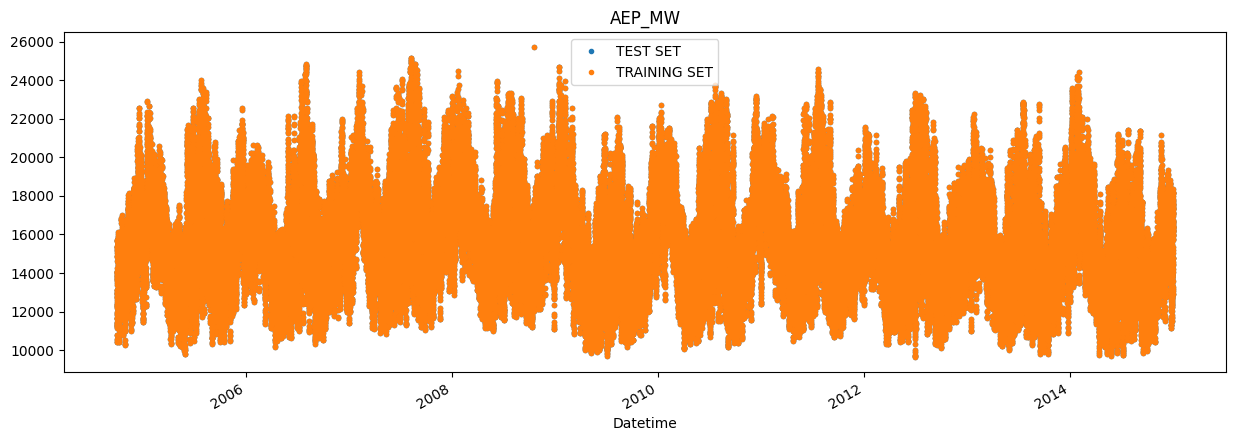

In [194]:
split_date = '01-Jan-2015'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()
_ = pjme_train.rename(columns={'AEP_MW': 'TEST SET'}).join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='AEP_MW', style='.')

# Từ ảnh trên ta thấy rằng việc tiêu thụ điện năng có xu hương giảm dần theo thời gian cụ thể nhìn vào các năm từ 2004 đến 2016 đang có xu hướng sử dụng trên 22000 rất nhiều nhưng qua các năm từ 2015 đến 2018 đang có dấu hiệu giảm lượng điện tiêu thụ xuống

Để làm rõ việc này chúng ta sẽ chia dữ liệu này nhỏ xuống theo các mức mặc đình là ngày giờ, phút, tháng,...

In [195]:
df['date'] = df.index
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['weekday_name'] = df['date'].dt.day_name()
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_month'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.weekofyear

df.head()

,AEP_MW,date,hour,day_of_week,weekday_name,quarter,month,year,day_of_year,day_of_month,week_of_year
Datetime,,,,,,,,,,,
2004-12-31 01:00:00,13478.0,2004-12-31 01:00:00,1,4,Friday,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2004-12-31 02:00:00,2,4,Friday,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,2004-12-31 03:00:00,3,4,Friday,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,2004-12-31 04:00:00,4,4,Friday,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,2004-12-31 05:00:00,5,4,Friday,4,12,2004,366,31,53


# Các hàm mặc định để vẽ trực quan dữ liệu

In [196]:
def line_plot(df, date, AEP, text, y_tiltle, x_title):
    data = go.Scatter(x = df[date],
                      y = df[AEP],
                      mode = 'lines',
                      name = AEP)

    layout = go.Layout(title={'text': text,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = x_title),
                       yaxis = dict(title = y_tiltle),
                       template = 'plotly_dark')

    fig = go.Figure(data = data, layout = layout)
    iplot(fig)

# ---------------------------------------
def new_df(df, col, new_date, new_AEP, split):
    tmp_df = df[[col]].reset_index().rename(columns={'Datetime':new_date, 'AEP_MW':new_AEP})
    tmp_df = pd.DataFrame(tmp_df.resample(split, on='Datetime', origin = 'start').mean())
    tmp_df.reset_index(inplace=True)
    return tmp_df

# ---------------------------------------
def bar_plot(col1, col2, agg_func, title, xtitle, ytitle):
    data = go.Bar(x = df.groupby(col1).agg({col2: agg_func}). \
              reset_index()[col1],
              y = df.groupby(col1).agg({col2: agg_func}). \
              reset_index()[col2],
              text =round(df.groupby(col1).agg({col2: agg_func}).reset_index()[col2],2),
              textposition= 'outside')

    layout = go.Layout(title={'text': title,
                              'y':0.9,
                              # 'x':0.5,
                              # 'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = xtitle),
                       yaxis = dict(title = ytitle),
                       template = 'plotly_dark')

    fig = go.Figure(data = data, layout = layout)
    iplot(fig)


# ---------------------------------------
def box_plot(q_num, col1, col2, color, title, xtitle, ytitle):
    box = go.Box(x = df.loc[df['quarter']==q_num][col1],
                       y = df.loc[df['quarter']==q_num][col2],
                       name = col1,
                       marker_color= color)

    layout = go.Layout(title={'text': title,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = xtitle),
                       yaxis = dict(title = ytitle),
                       template = 'plotly_dark')


    fig = go.Figure(data = box, layout = layout)
    iplot(fig)


# ---------------------------------------
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Xem xét về ngày của dữ liệu

In [197]:
df_daily = new_df(df, 'AEP_MW', 'Datetime', 'AEP_daily', 'D')
df_daily.head()
line_plot(df_daily, 'Datetime', 'AEP_daily', 'American Electric Power - Daily', 'AEP_MW_daily', 'Year')

Được ảo hóa dữ liệu theo ngày:

+ Dữ liệu có vẫn có xu hướng sử dụng giảm xuống và tăng giảm theo chu kỳ nào đó tổng quan chúng dữ liệu tăng giảm theo chu kỳ giao động từ mức 14k đến 18k lượng sử dụng điện

+ Luôn luôn ở mỗi năm luôn có những ngày tăng cao hơn nhiều so với nhưng ngày bình thường và từ năm 2010 đến 2014 dữ liệu tăng giảm theo từng ngày hầu như ổn định

# Ta chuyển đổi dữ liệu theo tháng

In [198]:
df_month = new_df(df, 'AEP_MW', 'Datetime', 'AEP_daily', 'M')

line_plot(df_month, 'Datetime', 'AEP_daily', 'American Electric Power - Month', 'AEP_MW_month', 'Year')

# Dữ liệu theo tháng mượt hơn dữ liệu theo ngày và thể hiện xu hướng rõ ràng hơn dữ liệu theo năm:
+ Dầu tiên dữ liệu sử dụng điện cao nhất từ năm 2007 đến 2008 và có dấu hiệu giảm đều đặn theo từng năm vẫn có nhưng thàng tăng mạnh nhưng quy chung xu hướn vẫn là giảm

+ Nhìn vào dữ liệu theo tháng ta biết chắc rằng có thể sẽ có nhưng tháng dữ liệu biến động và lượng điện năng được sử dụng khó lường có thể là thiếu điện

In [199]:
bar_plot('year', 'AEP_MW', 'sum', 'Total American electric power consumption per year',
         'Year', 'AEP_MW')

# Trung bình dữ liệu tiêu thụ điện qua từng năm có xu hướn không chênh lệch nhau nhiều ở những năm 2004 và 2018 dữ liệu chưa tròn vẹn và đầy đủ 1 năm nên mới xảy ra hiện tượng lệch giá trị trung bình so với các dữ liệu khác

In [200]:
df_pivot = df.pivot_table(index=df['hour'], columns='weekday_name', values='AEP_MW',
               aggfunc='sum')
df_pivot = df_pivot[['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday']].reset_index().rename(columns={'hour':'hour'})

Monday = go.Scatter(x = df_pivot['hour'],
                  y = df_pivot['Monday'],
                  mode = 'lines',
                  name = 'Monday')

Tuesday = go.Scatter(x = df_pivot['hour'],
                  y = df_pivot['Tuesday'],
                  mode = 'lines',
                  name = 'Tuesday')

Wednesday = go.Scatter(x = df_pivot['hour'],
                  y = df_pivot['Wednesday'],
                  mode = 'lines',
                  name = 'Wednesday')

Thursday = go.Scatter(x = df_pivot['hour'],
                  y = df_pivot['Thursday'],
                  mode = 'lines',
                  name = 'Thursday')

Friday = go.Scatter(x = df_pivot['hour'],
                  y = df_pivot['Friday'],
                  mode = 'lines',
                  name = 'Friday')

Saturday = go.Scatter(x = df_pivot['hour'],
                  y = df_pivot['Saturday'],
                  mode = 'lines',
                  name = 'Saturday')

Sunday = go.Scatter(x = df_pivot['hour'],
                  y = df_pivot['Sunday'],
                  mode = 'lines',
                  name = 'Sunday')

layout = go.Layout(title={'text': 'American electric power consumption - hourly trends',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Hour'),
                   yaxis = dict(title = 'AEP_MW'),
                   template = 'plotly_dark')

data = [Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

# Dữ liệu thể hiện tiêu thụ điện của các thứ trong các giờ:
+ Được trải dài theo 24 giờ: ta thấy rằng dữ liệu có xu hướng  ở những ngày đầu của tháng dữ liệu theo các thứ ta thấy có xu hướng giảm dần vào buổi sáng 0h đến 5h sáng, có thể đây là lúc mọi người đi vào giờ ngủ
+ Tiếp theo nó tăng dần qua các giờ sáng đến chiều lúc thời gian đi làm việc và về nhà của các hộ gia đình hay nhà máy xí nghiệp
+ Tới 20h tối có xu hướng giảm từ từ xuống
+ Đặc biệt là sunday lượng điện tiêu thụ giảm hơn so với các ngày trong tuần và thứ 4 củng có xu hướng giảm so với các ngày khác

In [201]:
box_plot(1, 'hour', 'AEP_MW', '#65e3fc', 'American electric power consumption per year in Q1',
            'Hour', 'AEP_MW')

In [202]:
box_plot(2, 'hour', 'AEP_MW', '#65fc67', 'American electric power consumption per year in Q2',
            'Hour', 'AEP_MW')

# <a name='link3'>  3. Data Pre-processing (EDA)</a>


# Chúng ta sẽ thêm nhiều thông về thời gian cho dữ liệu train test để có sự đa dạng về thông tin cho train và test

In [203]:
def create_features(data, label = "AEP_MW"):
  X, y = data.drop([label], axis = 1), data[label]
  X['date'] = X.index
  X['hour'] = X['date'].dt.hour
  X['day_of_week'] = X['date'].dt.dayofweek
  X['weekday_name'] = X['date'].dt.day_name()
  X['quarter'] = X['date'].dt.quarter
  X['month'] = X['date'].dt.month
  X['year'] = X['date'].dt.year
  X['day_of_year'] = X['date'].dt.dayofyear
  X['day_of_month'] = X['date'].dt.day
  X['week_of_year'] = X['date'].dt.weekofyear
  return X, y

In [204]:
X_train,y_train = create_features(pjme_train, label = "AEP_MW")
X_test,y_test = create_features(pjme_test, label = "AEP_MW")
X_train, X_test = X_train.drop(["date"], axis =1), X_test.drop(["date"], axis =1 )

In [205]:
# Tạo một từ điển ánh xạ các tên của ngày trong tuần sang số
weekday_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# Ánh xạ giá trị của cột "weekday_name" theo từ điển trên
X_train['weekday_name'] = X_train['weekday_name'].map(weekday_map)
X_test['weekday_name'] = X_test['weekday_name'].map(weekday_map)


**Tạo ra x_train, x_test cho model bằng predict của hai model rf và xb**

### Đối với bài toán này tôi quan tâm đến các outlier nhiều hơn vì đây là những cái cần dự đoán đúng nhất nhưng khi để outlier quá nhiều vào bài toán regression có thể làm cho các model dự đoán bị sai lệch nhiều so với thực tế cụ thể là những ngày bình thường nên tối quyết định sẽ là một cách như sau:

Dúng isolation forest để có thể loại bỏ bớt các outler nằm trong dữ liệu train đi chứ không nhằm mục đích loại bỏ hết mọi thứ. Sau đó, dữ liệu vẫn sẽ còn những ngày bị outlier để tập trung vào dự đoán cho từ năm 2015 đến năm 2018

In [206]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
# Hàm loại bỏ bớt outlier trong dữ liệu
def remove_outliers(X, y, method='IsolationForest', contamination=0.1, random_state=None):
    if method == 'IsolationForest':
        # Sử dụng Isolation Forest để loại bỏ outlier trên cả X và y
        model = IsolationForest(contamination=contamination, random_state=random_state)
        y_pred = model.fit_predict(X)
    elif method == 'LocalOutlierFactor':
        # Sử dụng Local Outlier Factor để loại bỏ outlier trên cả X và y
        model = LocalOutlierFactor(contamination=contamination)
        y_pred = model.fit_predict(X)
    else:
        raise ValueError("Method must be either 'IsolationForest' or 'LocalOutlierFactor'")

    # Trả về chỉ mục của các mẫu không phải là outlier
    indices = np.where(y_pred == 1)[0]

    # Trả về dữ liệu sau khi loại bỏ outlier trên cả X và y
    return X.iloc[indices], y.iloc[indices]
X_train, y_train = remove_outliers(X_train, y_train)

**Lấy dữ liệu train test đã tạo ra từ drive vào**

In [207]:
y_train_temp = y_train.copy()

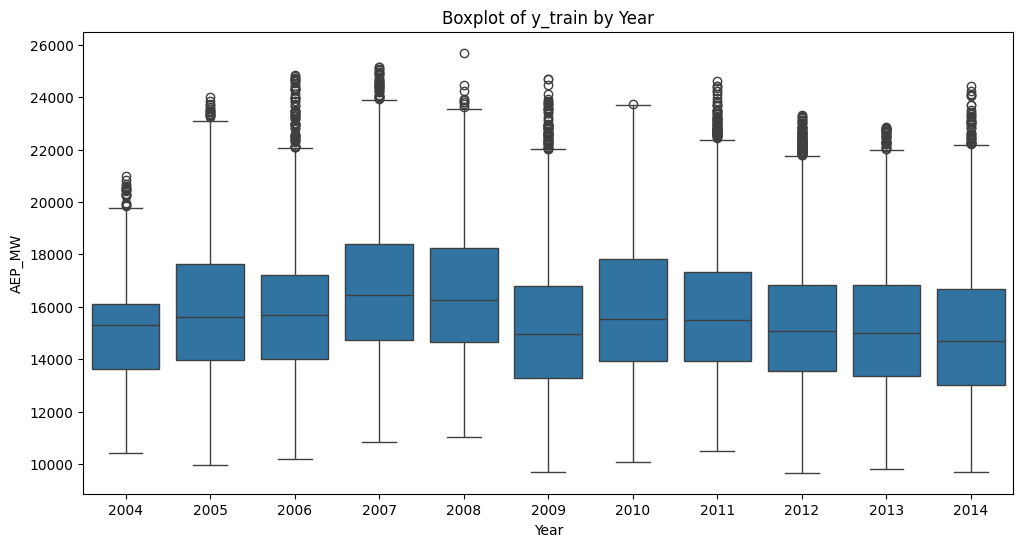

In [208]:
# Tạo cột 'Year' để chia dữ liệu thành các nhóm theo từng năm
y_train_df = y_train_temp.to_frame()
y_train_df['Year'] = y_train_df.index.year

# Vẽ boxplot từng năm
plt.figure(figsize=(12, 6))
sns.boxplot(data=y_train_df, x='Year', y='AEP_MW')
plt.title('Boxplot of y_train by Year')
plt.xlabel('Year')
plt.ylabel('AEP_MW')
plt.show()


# <a name='link4'>  4. Model Evaluation</a>

### Các model dùng để ddahs giá gồm rf, LSTM và adaboost

**Hàm tính sai số **

In [209]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Model linear**

In [210]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# RandomForest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# AdaBoost model
adaboost_model = AdaBoostRegressor()
adaboost_model.fit(X_train, y_train)


AdaBoostRegressor()

In [212]:
predict_rf = rf_model.predict(X_test)
predict_ada = adaboost_model.predict(X_test)

print("Model rf acc: ", mean_absolute_percentage_error(y_test, predict_rf))
print("Model ada acc: ", mean_absolute_percentage_error(y_test, predict_ada))

Model rf acc:  9.805564694180601
Model ada acc:  13.388559368158509


In [218]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test.index, test, color='blue', label='Actual power consumption data')
    plt.plot(test.index, predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()


In [ ]:
plot_predictions(y_test, predict_rf, title = "rf predict")

 Ta thấy rằng dự đoán của model rf gần như đúng và tốt trong năm 2015 và có sự dự đoán lệch so với thằng 07-2016 đến 01 2017 rất nhiều. Từ năm 2018 dự đoán ổn định hơn rất nhiều và có phần chín xác

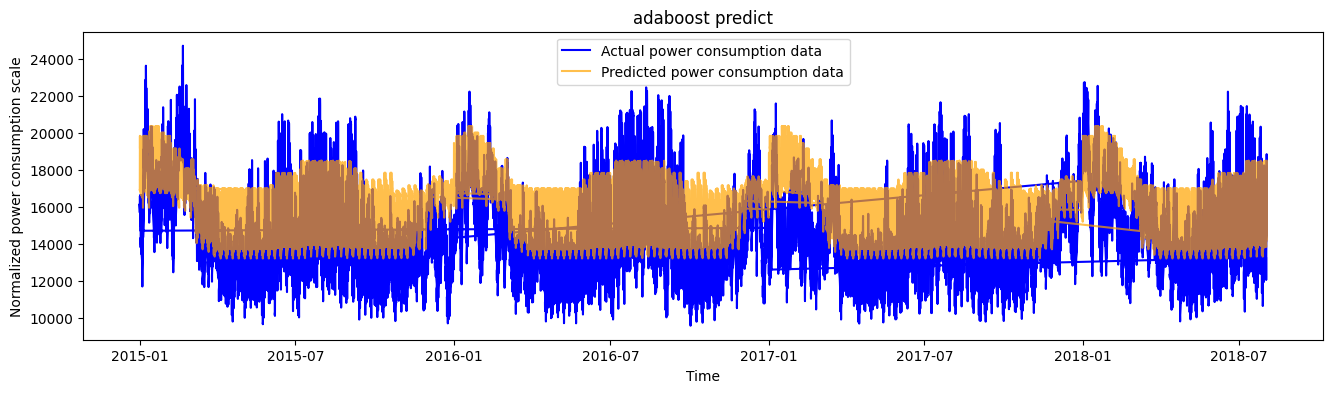

In [220]:
plot_predictions(y_test, predict_ada, title = "adaboost predict")

Đối với adaboost đã có sự dự đoán về regressor không được tốt ta thấy rằng dữ đoán được đưa ra có phần không khớp với thực tế vf thiếu ít hơn dữ liệu so với yêu cầu adaboost dự đoán rất tốt nhưng ngày bth cần dùng nhiều điện năng nhưng những ngày cần dùng ít lại đi quá xa

# Tuning model

# CHúng tôi sử dụng bayesian search cho tìm kiếm tốt nhất với 80% từ dữ liệu test trong quá khứ cho việc tìm kiếm parameter tốt nhất cho từng model

In [233]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from skopt.space import Real, Integer, Categorical
np.int = int
# Định nghĩa không gian tìm kiếm cho RandomForest
rf_param_dist = {
    'n_estimators': Integer(50, 100),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 8),
    'min_samples_leaf': Integer(1, 5),
    'bootstrap': Categorical([True, False])
}

# Định nghĩa không gian tìm kiếm cho AdaBoost
adaboost_param_dist = {
    'n_estimators': Integer(50, 200),
    'learning_rate': Real(0.01, 1.0, 'uniform')
}

# Tạo đối tượng BayesSearchCV cho RandomForest
rf_bayes_search = BayesSearchCV(
    RandomForestRegressor(),
    rf_param_dist,
    n_iter=10,
    cv=2,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Tạo đối tượng BayesSearchCV cho AdaBoost
adaboost_bayes_search = BayesSearchCV(
    AdaBoostRegressor(),
    adaboost_param_dist,
    n_iter=10,
    cv=2,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Số lượng mẫu bạn muốn lấy cho tập huấn luyện (80%)
n_samples_train = int(0.8 * len(X_train))

# Chọn 80% dữ liệu từ tập huấn luyện
X_train_subset = X_train[:n_samples_train]
y_train_subset = y_train[:n_samples_train]

# Thực hiện tìm kiếm Bayes cho RandomForest trên dữ liệu nhỏ
rf_bayes_search.fit(X_train_subset, y_train_subset)

# Thực hiện tìm kiếm Bayes cho AdaBoost trên dữ liệu nhỏ
adaboost_bayes_search.fit(X_train_subset, y_train_subset)



Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

BayesSearchCV(cv=2, estimator=AdaBoostRegressor(), n_iter=10, n_jobs=-1,
              random_state=42,
              search_spaces={'learning_rate': Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize')},
              verbose=2)

In [235]:
best_rf_params = rf_bayes_search.best_params_
best_adaboost_params = adaboost_bayes_search.best_params_

# Huấn luyện mô hình RandomForest với các tham số tốt nhất
best_rf_model = RandomForestRegressor(**best_rf_params)
best_rf_model.fit(X_train, y_train)

# Dự đoán trên tập dữ liệu test với mô hình RandomForest
rf_predictions = best_rf_model.predict(X_test)

# Huấn luyện mô hình AdaBoost với các tham số tốt nhất
best_adaboost_model = AdaBoostRegressor(**best_adaboost_params)
best_adaboost_model.fit(X_train, y_train)

# Dự đoán trên tập dữ liệu test với mô hình AdaBoost
adaboost_predictions = best_adaboost_model.predict(X_test)

In [236]:
print("Model rf best acc: ", mean_absolute_percentage_error(y_test, rf_predictions))
print("Model ada best acc: ", mean_absolute_percentage_error(y_test,adaboost_predictions))

Model rf best acc:  10.891298673785267
Model ada best acc:  13.50854967722827


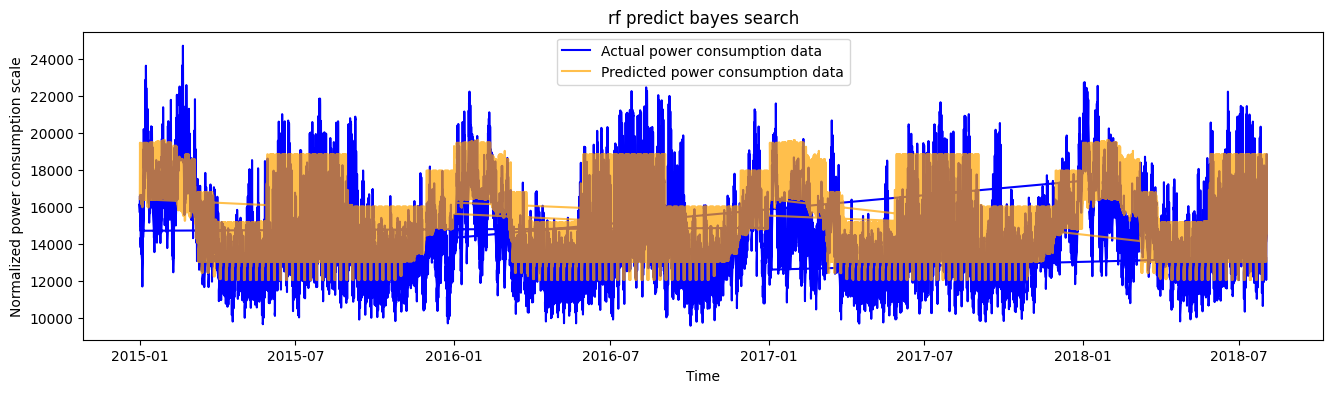

In [237]:
plot_predictions(y_test, rf_predictions, title = "rf predict bayes search")

# rf không tốt hơn sau khi tunin bằng bayes search vì có những chổ đi ngang rất nhiều và có những ngày dự đoán xa với dự thwucj tế

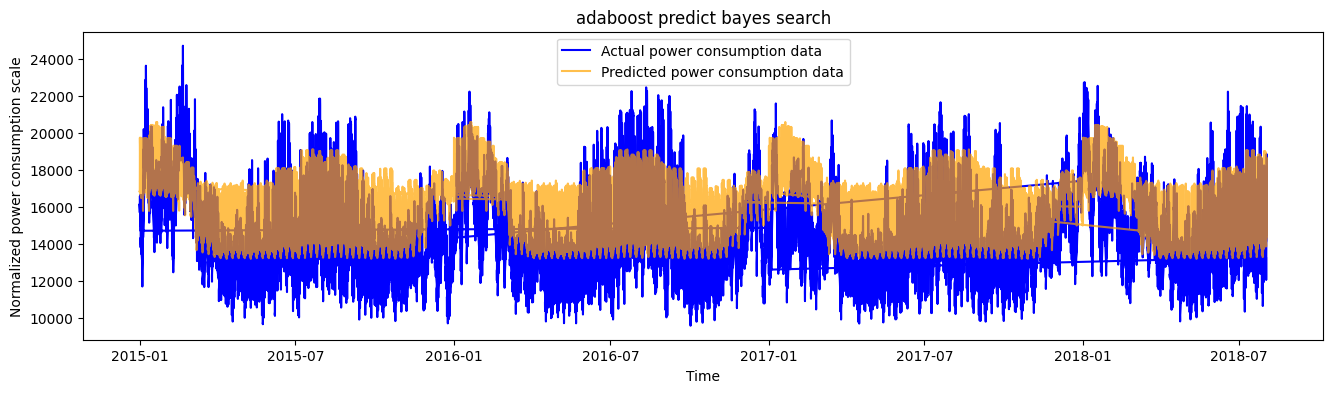

In [238]:
plot_predictions(y_test, adaboost_predictions, title = "adaboost predict bayes search")

# Dự đoán của ada cho tấy nó đang tốt với những lúc cần điện nhất.

# LSTM model

In [248]:
X_train_lstm = np.array(X_train)
y_train_lstm = np.array(y_train)

X_test_lstm = np.array(X_test)
y_test_lstm = np.array(y_test)

# 4 reshape data to input into RNN models
sep_len = 20
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 9, 1))

X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], 9, 1))

In [249]:
X_train_lstm

array([[[  1],
        [  4],
        [  5],
        ...,
        [359],
        [ 24],
        [ 52]],

       [[  2],
        [  4],
        [  5],
        ...,
        [359],
        [ 24],
        [ 52]],

       [[  3],
        [  4],
        [  5],
        ...,
        [359],
        [ 24],
        [ 52]],

       ...,

       [[ 15],
        [  2],
        [  3],
        ...,
        [  8],
        [  8],
        [  2]],

       [[ 16],
        [  2],
        [  3],
        ...,
        [  8],
        [  8],
        [  2]],

       [[ 18],
        [  2],
        [  3],
        ...,
        [  8],
        [  8],
        [  2]]])

In [255]:
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential


lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=1000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 9, 40)             6720      
                                                                 
 dropout_3 (Dropout)         (None, 9, 40)             0         
                                                                 
 lstm_4 (LSTM)               (None, 9, 40)             12960     
                                                                 
 dropout_4 (Dropout)         (None, 9, 40)             0         
                                                                 
 lstm_5 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [256]:
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_score = r2_score(y_test_lstm, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

983/983 [==============================] - 7s 6ms/step
R^2 Score of LSTM model =  -34.42210408279967


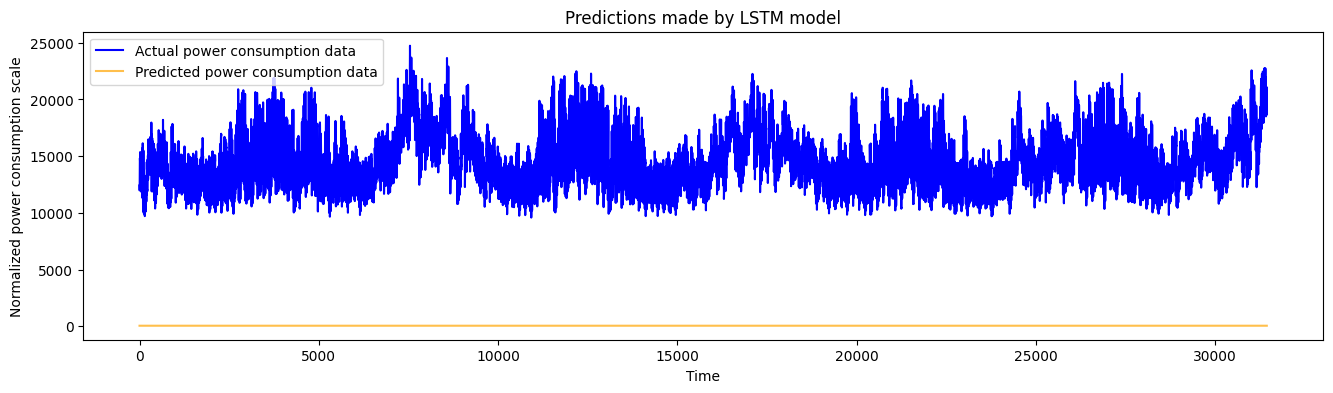

In [258]:

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

plot_predictions(y_test_lstm, lstm_predictions, "Predictions made by LSTM model")

# Dự đoán của LSTM sai quá nhiều và chỉ 1 con số so với thực tế cho nên model đã bị overfitting

# <a name='link5'>  5. Final Models  </a>

---



# Model cuối cùng được chọn là model rf rất vượt trội về sức mạnh và dự đoán so với ada và lstm

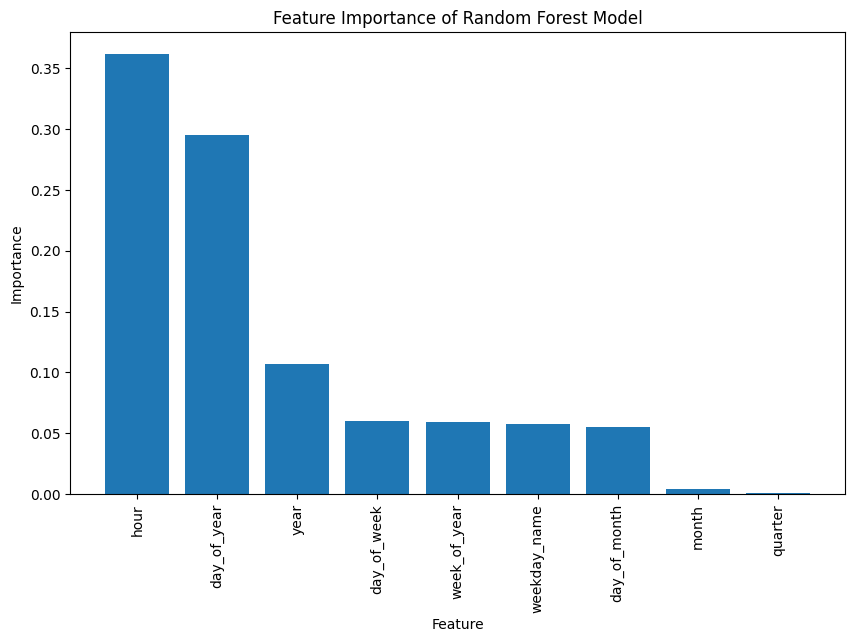

In [260]:

# Lấy độ quan trọng của các feature
feature_importance = rf_model.feature_importances_

# Sắp xếp các feature theo độ quan trọng giảm dần
sorted_indices = np.argsort(feature_importance)[::-1]

# Lấy tên của các feature
feature_names = X_train.columns

# Vẽ biểu đồ feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(feature_importance)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Model')
plt.show()


# Đối với imprtant được đánh giá cao nhất là giờ:
+ Giờ nào với ngày của năm nào là quan trọng có thể nói đến việc là có những ngày đặc biệt của năm và giờ đó sẽ tiêu tốn nhiều năng lượng điện
+ Năm nào ngày nào và giờ nào củng là cách quan trọng trong việc tính toán sử dụng điện
+ Ngày nào của tuần nào là tốt và cụ thể năm nào giờ nào
+ cuối cùng tháng và quý không quyết định nhiều lắm trong việc sử dụng điện